In [119]:
import os
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from src.wimbd_ import BasePaths as PATHS
from src.wimbd_ import DataConfigs as CONFIG
from src.wimbd_ import post_filter, filter_percentile, load_results
from src.wimbd_ import ProcessTriviaQA as ptqa
from src.utils import remove_nested_lists
from src.analysis import AnalyzeNgrams as an
from wimbd_process_results import softmax

from datetime import datetime
pd.set_option('display.max_columns', 10)

# Generate a timestamp
timestamp = datetime.now().strftime("%Y-%m-%d-%H:%M")

In [120]:
task_coverage_pth = "./results/n-grams/triviaqa/pile/exp_3/validation-set/n_samples_None_fkeyFalse_rkeyFalse_fstopTrue_onlyalphaFalse/3/common/task-p-coverage.pkl"
task_coverage = pd.read_pickle(task_coverage_pth)

In [121]:
all_models = ['pythia-12b', 'pythia-6.9b', 'pythia-2.8b', 'pythia-1.4b', 'pythia-410m', 'pythia-160m', 'pythia-70m', 'pythia-31m', 'pythia-14m']
large_models = ['pythia-12b', 'pythia-6.9b', 'pythia-2.8b', 'pythia-1.4b']
small_models = ['pythia-410m', 'pythia-160m', 'pythia-70m', 'pythia-31m', 'pythia-14m']

N_GRAMS = 5
ALIGN_THRESH = 85
# BASE_DIR = f"./results/n-grams/trivia_qa/pile/exp_3/test-set/n_samples_None_fkeyFalse_rkeyFalse_fstopTrue_onlyalphaFalse/"
# BASE_DIR = f"./results/n-grams/triviaqa/pile/exp_3/validation-set/n_samples_None_fkeyFalse_rkeyFalse_fstopTrue_onlyalphaFalse/"
BASE_DIR = f"./results/n-grams/triviaqa/pile/exp_3/validation-set/n_samples_None_fkeyFalse_rkeyFalse_fstopFalse_onlyalphaFalse"
DATASET = "examples_dfs_4-shot_common_models.pkl"
TASKS = "triviaqa"
OMMIT_TASKS = False
TASKS_OMMIT = ["formal_logic"]
POST_FILTER = True

# BASE_DIR = PATHS.base_ngram_paths[TASKS]['base_path']
BASE_PATH = os.path.join(BASE_DIR, f"{N_GRAMS}")
METHOD = "0-shot_common"
BASE_PATH_COMMON = os.path.join(BASE_PATH, "common")
BASE_PATH_ALL = os.path.join(BASE_PATH, "all")
# FIG_DIR = os.path.join("/share/edc/home/antonis/LLM-Incidental-Supervision/incidental-supervision/figures", DATASET, timestamp)
# if not os.path.exists(FIG_DIR):
#     os.makedirs(FIG_DIR)

# RESULTS_PATH = os.path.join(BASE_DIR, str(N_GRAMS), 'common', DATASET)
RESULTS_PATH = os.path.join(BASE_DIR, str(N_GRAMS), DATASET)
FIGS_PTH = "./figures/trivia_qa"

print(f"BASE PATH: {BASE_PATH}")

VIEW_COLS = ['Q', 'A', 'question', 'value', 'align_score', 'em', 'answer']

BASE PATH: ./results/n-grams/triviaqa/pile/exp_3/validation-set/n_samples_None_fkeyFalse_rkeyFalse_fstopFalse_onlyalphaFalse/5


In [122]:
"./results/n-grams/triviaqa/pile/exp_3/validation-set/n_samples_None_fkeyFalse_rkeyFalse_fstopTrue_onlyalphaFalse/3/examples_dfs_4-shot_common_models.pkl"

'./results/n-grams/triviaqa/pile/exp_3/validation-set/n_samples_None_fkeyFalse_rkeyFalse_fstopTrue_onlyalphaFalse/3/examples_dfs_4-shot_common_models.pkl'

In [123]:
RESULTS_PATH == "./results/n-grams/triviaqa/pile/exp_3/validation-set/n_samples_None_fkeyFalse_rkeyFalse_fstopTrue_onlyalphaFalse/3/examples_dfs_4-shot_common_models.pkl"

False

In [126]:
RESULTS_PATH

'./results/n-grams/triviaqa/pile/exp_3/validation-set/n_samples_None_fkeyFalse_rkeyFalse_fstopFalse_onlyalphaFalse/5/examples_dfs_0-shot_common_models.pkl'

In [125]:
# filter outliers
pickle_file = pd.read_pickle(RESULTS_PATH)
# df = pd.DataFrame(pickle_file).T.sort_values("value", ascending=False)


# filter
# open
examples_models_pth = os.path.join(BASE_PATH, f"examples_dfs_{METHOD}_post-processed.pkl")
if os.path.exists(examples_models_pth):
    with open(examples_models_pth, 'rb') as f:
        examples_models = pickle.load(f)
else:
    examples_models = ptqa.process_model_examples(pickle_file, p=0.99999)
examples_model = examples_models['pythia-12b']
colors = sns.color_palette('hls', len(examples_models))

FileNotFoundError: [Errno 2] No such file or directory: './results/n-grams/triviaqa/pile/exp_3/validation-set/n_samples_None_fkeyFalse_rkeyFalse_fstopFalse_onlyalphaFalse/5/examples_dfs_0-shot_common_models.pkl'

In [ ]:
examples_model.head(20)

,Q,A,value,example,task,...,answer,lls,result,em,align_score
25,in the middle of the,Pear,1837603,"{'question': 'Which fruit can go in the middle of the word aped to make a new word?', 'question_id': 'qz_871', 'question_source': 'https://www.quiz-zone.co.uk/', 'entity_pages': {'doc_source': [], 'filename': [], 'title': [], 'wiki_context': []}, 'search_results': {'description': [], 'filename': [], 'rank': [], 'title': [], 'url': [], 'search_context': []}, 'answer': {'aliases': ['Pear (fruit)', 'Pear tree', 'Pear', 'Culture of pear', '🍐', 'Pear juice', 'Pearwood', 'Pyrus'], 'normalized_aliases': ['🍐', 'culture of pear', 'pyrus', 'pearwood', 'pear tree', 'pear juice', 'pear', 'pear fruit'], 'matched_wiki_entity_name': '', 'normalized_matched_wiki_entity_name': '', 'normalized_value': 'pear', 'type': 'WikipediaEntity', 'value': 'Pear'}}",triviaqa,...,"{'aliases': ['Pear (fruit)', 'Pear tree', 'Pear', 'Culture of pear', '🍐', 'Pear juice', 'Pearwood', 'Pyrus'], 'normalized_aliases': ['🍐', 'culture of pear', 'pyrus', 'pearwood', 'pear tree', 'pear juice', 'pear', 'pear fruit'], 'matched_wiki_entity_name': '', 'normalized_matched_wiki_entity_name': '', 'normalized_value': 'pear', 'type': 'WikipediaEntity', 'value': 'Pear'}",Apple,Apple,0,78.528419
22,at the beginning of the,45,1815794,"{'question': 'How many American states were there at the beginning of the twentieth century?', 'question_id': 'odql_9796', 'question_source': 'http://www.odquiz.org.uk/', 'entity_pages': {'doc_source': [], 'filename': [], 'title': [], 'wiki_context': []}, 'search_results': {'description': [], 'filename': [], 'rank': [], 'title': [], 'url': [], 'search_context': []}, 'answer': {'aliases': ['45', 'forty-five'], 'normalized_aliases': ['45', 'forty five'], 'matched_wiki_entity_name': '', 'normalized_matched_wiki_entity_name': '', 'normalized_value': '45', 'type': 'Numerical', 'value': '45'}}",triviaqa,...,"{'aliases': ['45', 'forty-five'], 'normalized_aliases': ['45', 'forty five'], 'matched_wiki_entity_name': '', 'normalized_matched_wiki_entity_name': '', 'normalized_value': '45', 'type': 'Numerical', 'value': '45'}",Ten,Ten,0,76.193657
38,is the square root of,99,1022052,"{'question': 'What whole two-digit number is the square root of 9801?', 'question_id': 'bb_5981', 'question_source': 'http://www.businessballs.com/', 'entity_pages': {'doc_source': [], 'filename': [], 'title': [], 'wiki_context': []}, 'search_results': {'description': [], 'filename': [], 'rank': [], 'title': [], 'url': [], 'search_context': []}, 'answer': {'aliases': ['99', 'ninety-nine'], 'normalized_aliases': ['ninety nine', '99'], 'matched_wiki_entity_name': '', 'normalized_matched_wiki_entity_name': '', 'normalized_value': '99', 'type': 'Numerical', 'value': '99'}}",triviaqa,...,"{'aliases': ['99', 'ninety-nine'], 'normalized_aliases': ['ninety nine', '99'], 'matched_wiki_entity_name': '', 'normalized_matched_wiki_entity_name': '', 'normalized_value': '99', 'type': 'Numerical', 'value': '99'}",9,9,0,83.908638
37,is the square root of,12,1022052,"{'question': 'What is the square root of 144?', 'question_id': 'qb_7961', 'question_source': 'http://www.quizballs.com/', 'entity_pages': {'doc_source': [], 'filename': [], 'title': [], 'wiki_context': []}, 'search_results': {'description': [], 'filename': [], 'rank': [], 'title': [], 'url': [], 'search_context': []}, 'answer': {'aliases': ['twelve', '12'], 'normalized_aliases': ['twelve', '12'], 'matched_wiki_entity_name': '', 'normalized_matched_wiki_entity_name': '', 'normalized_value': '12', 'type': 'Numerical', 'value': '12'}}",triviaqa,...,"{'aliases': ['twelve', '12'], 'normalized_aliases': ['twelve', '12'], 'matched_wiki_entity_name': '', 'normalized_matched_wiki_entity_name': '', 'normalized_value': '12', 'type': 'Numerical', 'value': '12'}",12,12,1,84.854713
75,President of the United States,Ronald Reagan,615844,"{'question': 'June 5, 2004 saw the death of what man, the 40th President of the United States?', 'question_id': 'qg_1692'

In [ ]:
# # save
# with open(os.path.join(BASE_PATH, f"examples_dfs_{METHOD}_post-processed.pkl"), 'wb') as f:
#     pickle.dump(examples_models, f)

In [ ]:
examples_models_ = {model: data[data['align_score'] > ALIGN_THRESH] for model, data in examples_models.items()}

In [ ]:
# examples_model_small = examples_model.iloc[0:3]
# examples_model_small_filtered, indices_kept = ptqa.calculate_alignment_scores(examples_model_small, 75, 1)

In [ ]:
# display_cols = ['Q', 'A', 'value', 'example']
# pd.set_option('display.max_rows', 1000)
# pd.set_option('display.max_colwidth', 2)  # Set to None to display full content
# examples_model[display_cols].iloc[200:400]

In [ ]:
from src.analysis import AnalyzeNgrams as an

# coverage_path = os.path.join(BASE_PATH_COMMON, "task-coverage.pkl")
# task_cov = an.calculate_average_task_coverage(BASE_PATH_ALL, [TASKS], [N_GRAMS])

In [ ]:
# # Assuming 'value' is the column with values to bin and we want 5 bins between 1 and 10000
# examples_model = an.create_bins(examples_model, 'value', 1, 10000, 4)

# example_samples_model = ptqa.get_random_samples_by_interval(examples_model, 100)

# ptqa.plot_avg_em_by_log_interval(example_samples_model, log_axis=True)
# ptqa.plot_avg_em_by_log_interval(examples_model, log_axis=True)
# # plot_avg_em_by_log_interval(example_samples_model, log_axis=False)

In [ ]:
len(examples_models_['pythia-12b'])

24244

interval
[0.00, 1.00)          19005
[3.16, 177.83)        3460 
[0.06, 3.16)          1032 
[177.83, 10000.00)    720  
[10000, ∞)            27   
Name: count, dtype: int64
avg_df =                     interval_start     avg_y
interval                                    
[0.00, 1.00)        0.00            0.339805
[0.06, 3.16)        0.06            0.340116
[3.16, 177.83)      3.16            0.431503
[177.83, 10000.00)  177.83          0.508333
[10000, ∞)          10000.00        0.518519
avg_y: interval
[0.00, 1.00)          0.339805
[0.06, 3.16)          0.340116
[3.16, 177.83)        0.431503
[177.83, 10000.00)    0.508333
[10000, ∞)            0.518519
Name: avg_y, dtype: float64
Saved figure in ./figures/trivia_qa/avg_em_by_log_interval_all_logTrue_value_aligned85.png
interval
[0.00, 1.00)          19005
[3.16, 177.83)        3460 
[0.06, 3.16)          1032 
[177.83, 10000.00)    720  
[10000, ∞)            27   
Name: count, dtype: int64
avg_df =                     interva

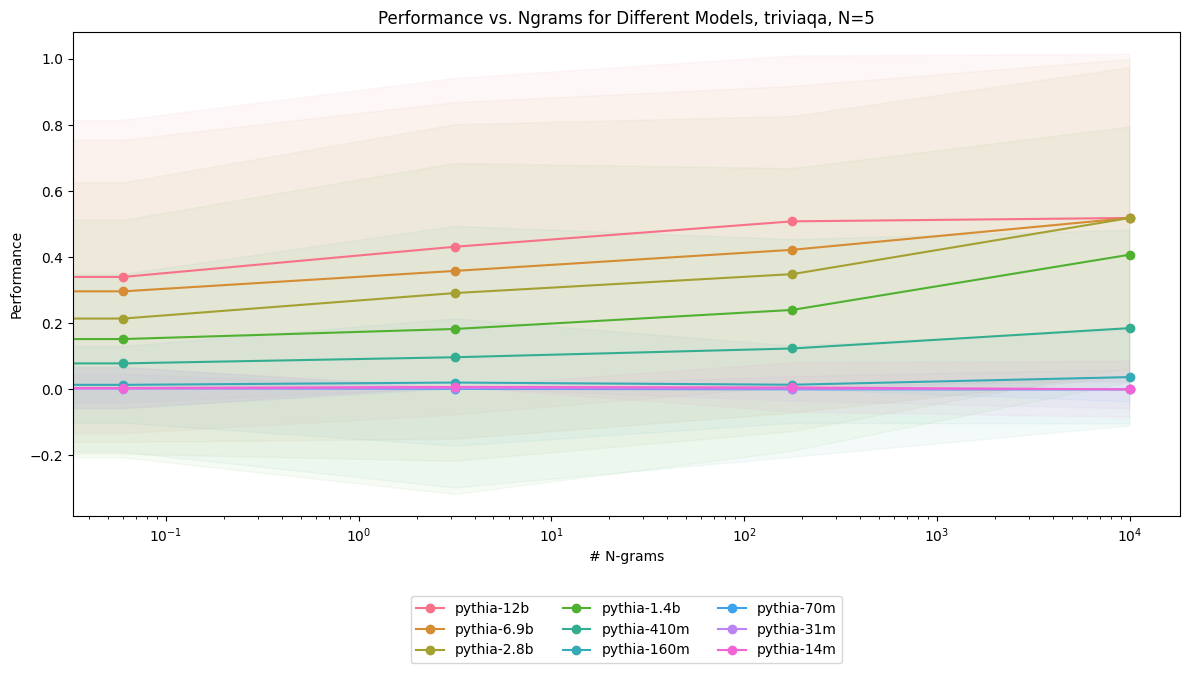

In [ ]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

color_palette = sns.color_palette('husl', len(examples_models))
is_log = True
plot_var = 'value'
savefile = os.path.join(FIGS_PTH, f"avg_em_by_log_interval_all_log{is_log}_{plot_var}_aligned{ALIGN_THRESH}.png")
for i, (model_name, data) in enumerate(examples_models_.items()):
    data = an.create_bins(data, plot_var, 0, 10000, 8, is_log)
    # data = ptqa.get_random_samples_by_interval(data, 85)
    ax = ptqa.plot_variable_by_interval(data, log_axis=is_log,
                                 x_column='interval', y_column='em',
                                 save_pth=savefile, ax=ax, 
                                 color=color_palette[i], label=model_name,
                                 title=f'Performance vs. Ngrams for Different Models, {TASKS}, N={N_GRAMS}',
                                 plot_std=True)

In [ ]:
examples_model = examples_models['pythia-12b']
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 500)
# Corrected code
pd.set_option('display.max_colwidth', 1)
examples_model[VIEW_COLS].head(5)

,Q,A,question,value,align_score,em,answer
25,in the middle of the,Pear,Which fruit can go in the middle of the word aped to make a new word?,1837603,78.528419,0,"{'aliases': ['Pear (fruit)', 'Pear tree', 'Pear', 'Culture of pear', '🍐', 'Pear juice', 'Pearwood', 'Pyrus'], 'normalized_aliases': ['🍐', 'culture of pear', 'pyrus', 'pearwood', 'pear tree', 'pear juice', 'pear', 'pear fruit'], 'matched_wiki_entity_name': '', 'normalized_matched_wiki_entity_name': '', 'normalized_value': 'pear', 'type': 'WikipediaEntity', 'value': 'Pear'}"
22,at the beginning of the,45,How many American states were there at the beginning of the twentieth century?,1815794,76.193657,0,"{'aliases': ['45', 'forty-five'], 'normalized_aliases': ['45', 'forty five'], 'matched_wiki_entity_name': '', 'normalized_matched_wiki_entity_name': '', 'normalized_value': '45', 'type': 'Numerical', 'value': '45'}"
38,is the square root of,99,What whole two-digit number is the square root of 9801?,1022052,83.908638,0,"{'aliases': ['99', 'ninety-nine'], 'normalized_aliases': ['ninety nine', '99'], 'matched_wiki_entity_name': '', 'normalized_matched_wiki_entity_name': '', 'normalized_value': '99', 'type': 'Numerical', 'value': '99'}"
37,is the square root of,12,What is the square root of 144?,1022052,84.854713,1,"{'aliases': ['twelve', '12'], 'normalized_aliases': ['twelve', '12'], 'matched_wiki_entity_name': '', 'normalized_matched_wiki_entity_name': '', 'normalized_value': '12', 'type': 'Numerical', 'value': '12'}"
75,President of the United States,Ronald Reagan,"June 5, 2004 saw the death of what man, the 40th President of the United States?",615844,82.827179,1,"{'aliases': ['President Regan', 'Ronald Reagan's Alzheimer's letter', 'Ronald W Reagan', '40th President of the United States', 'Reagan', 'Reaganian', 'Ronald Reagon', 'Reagen', 'Ronnie Reagan', 'Public image of Ronald Reagan', 'Ronald Reagan presidential campaign, 1976', 'Ronald Reagan', 'Reagan, Ronald', 'Reagan, Ronald Wilson', 'President Reagan', 'Reagan (president)', 'Health of Ronald Reagan', 'President Ronald Reagan', 'Ronald Reagan Centennial Commission Act', 'Ronald reagan', 'Reaganesque', 'Reaganite', 'Ronald Raegen', 'Ronald regean', 'Ronald Wilson Reagan', 'Ronald Regan', 'Ronald Reagan Centennial Commission', 'Dutch Reagan', 'Ronaldus Magnus', 'Ronald Reagen', 'Cultural and political image of Ronald Reagan', 'Ronal Reagan', 'Reagan Ronald', 'Ronald Raegan', 'Ronald W. Reagan'], 'normalized_aliases': ['reagan ronald wilson', 'reaganesque', 'ronald raegan', 'ronald reagon', 'ronald reagan s alzheimer s letter', 'ronald reagan', 'ronald w reagan', 'president reagan', 'reagan', 'reaganite', 'ronnie reagan', 'public image of ronald reagan', 'ronald reagen', 'reagan president', 'ronald regean', 'ronald regan', 'ronald wilson reagan', 'dutch reagan', '40th president of united states', 'reagen', 'ronald reagan presidential campaign 1976', 'ronaldus magnus', 'president regan', 'president ronald reagan', 'ronal reagan', 'ronald reagan centennial commission', 'health of ronald reagan', 'ronald raegen', 'cultural and political image of ronald reagan', 'reaganian', 'ronald reagan centennial commission act', 'reagan ronald'], 'matched_wiki_entity_name': '', 'normalized_matched_wiki_entity_name': '', 'normalized_value': 'ronald reagan', 'type': 'WikipediaEntity', 'value': 'Ronald Reagan'}"


In [ ]:
question = "What is the medical term for high blood pressure?"
df_q = examples_model[examples_model['question'] == question]
df_q['Q']

18125    is the medical term for     
18123    term for high blood pressure
18124    medical term for high blood 
18122    the medical term for high   
18121    What is the medical term    
Name: Q, dtype: object

In [ ]:
from src.utils import normalize_string

# Apply the function to each row of the DataFrame
# examples_model[['q_coverage', 'a_coverage']] = examples_model.apply(calculate_qa_coverage, axis=1)

coverage_df = an.calculate_qa_coverage(examples_model)

Processing questions:   0%|          | 9/9163 [00:00<01:51, 82.37it/s]

Processing questions: 100%|██████████| 9163/9163 [01:22<00:00, 111.08it/s]


In [ ]:
coverage_df.head(1)

,question,q_coverage,a_coverage,em,total_coverage
0,Which fruit can go in the middle of the word aped to make a new word?,0.933333,1,0,0.966667


In [ ]:
coverage_df['q_coverage'].unique()

array([0.93333333, 0.91666667, 0.8       , 0.85714286, 0.76923077,
       0.875     , 0.7826087 , 0.85      , 0.92857143, 0.9375    ,
       0.92      , 0.82352941, 0.83333333, 0.80952381, 0.75      ,
       0.9       , 0.81818182, 0.92307692, 0.94444444, 0.84615385,
       0.9047619 , 0.84210526, 0.90909091, 0.88888889, 1.        ,
       0.94117647, 0.71052632, 0.69230769, 0.95833333, 0.81481481,
       0.77777778, 0.96      , 0.7804878 , 0.88461538, 0.86666667,
       0.66666667, 0.88235294, 0.71428571, 0.78571429, 0.76      ,
       0.7       , 0.8125    , 0.74074074, 0.86842105, 0.86956522,
       0.72222222, 0.92592593, 0.95454545, 0.95      , 0.78947368,
       0.89473684, 0.82608696, 0.90322581, 0.76190476, 0.88372093,
       0.96428571, 0.86206897, 0.70588235, 0.5625    , 0.94736842,
       0.73076923, 0.91304348, 0.84      , 0.82857143, 0.72727273,
       0.95652174, 0.76595745, 0.95238095, 0.73529412, 0.87179487,
       0.73333333, 0.87878788, 0.82142857, 0.80769231, 0.88   

In [ ]:
coverage_df[coverage_df['q_coverage'] < 0]

,question,q_coverage,a_coverage,em,total_coverage


interval
[0.7800, 1.0000)    6628
[0.5600, 0.7800)    2067
[1.0, ∞)            297 
[0.3400, 0.5600)    163 
[0.1200, 0.3400)    8   
Name: count, dtype: int64
avg_df =                   interval_start     avg_y
interval                                  
[0.1200, 0.3400)  0.12            0.125000
[0.3400, 0.5600)  0.34            0.306748
[0.5600, 0.7800)  0.56            0.355104
[0.7800, 1.0000)  0.78            0.374774
[1.0, ∞)          1.00            0.282828
avg_y: interval
[0.1200, 0.3400)    0.125000
[0.3400, 0.5600)    0.306748
[0.5600, 0.7800)    0.355104
[0.7800, 1.0000)    0.374774
[1.0, ∞)            0.282828
Name: avg_y, dtype: float64
Saved figure in ./figures/trivia_qa/avg_em_by_log_interval_all_logTrue_value_aligned85.png


<Axes: title={'center': 'Performance vs. q_coverage for Different Models N=5'}, xlabel='Question Coverage (p)', ylabel='Performance'>

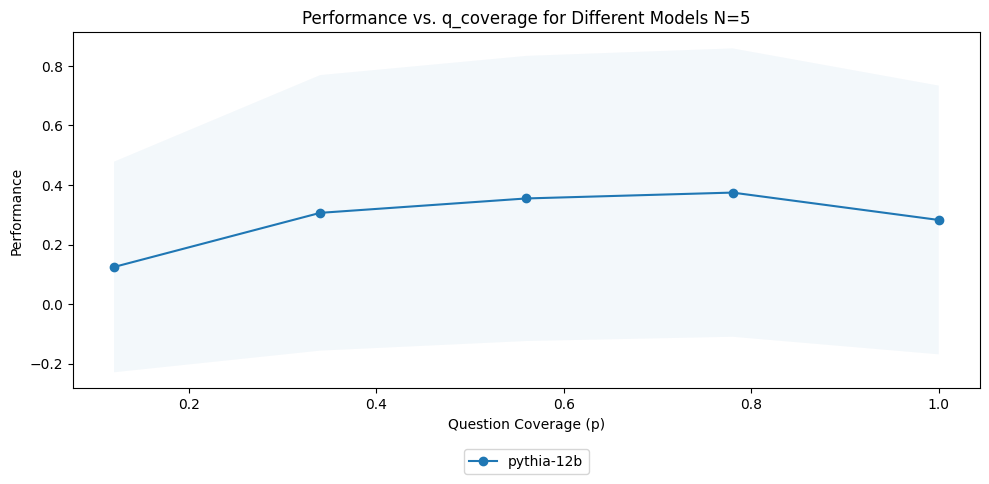

In [ ]:
is_log = False
plot_var = 'q_coverage'
x_label = 'Question Coverage (p)'

examples_model_cov_int = an.create_bins(coverage_df, plot_var, 
                                        -0.1, 1.0, 5, 
                                        is_log=is_log)

ptqa.plot_variable_by_interval(examples_model_cov_int, log_axis=is_log,
                                x_column='interval', y_column='em',
                                save_pth=savefile, 
                                label='pythia-12b',
                                title=f'Performance vs. {plot_var} for Different Models N={N_GRAMS}',
                                x_label=x_label, 
                                plot_std=True)

In [ ]:
def calculate_coverage(col_1, col_2):
    

SyntaxError: incomplete input (772524289.py, line 2)

In [ ]:
def calculate_coverage()

In [ ]:
examples_model.groupby('log_interval').count()